In [ ]:
!pip install torch torchvision
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17075, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 17075 (delta 29), reused 30 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17075/17075), 15.69 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (11723/11723), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 56.6 MB/s eta 0:00:00


In [ ]:
import torch
import cv2
from pathlib import Path
from google.colab.patches import cv2_imshow
import sys
import os
sys.path.append(str(Path('yolov5')))  # Adiciona o repositório YOLOv5 ao caminho

from models.experimental import attempt_load
from utils.general import non_max_suppression
from utils.torch_utils import select_device
from google.colab.patches import cv2_imshow

# Selecionar o dispositivo (CPU ou GPU)
device = select_device('cuda' if torch.cuda.is_available() else 'cpu')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CPU



In [ ]:
#ocultar
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Passo 1: Configuração para o treinamento
# O arquivo data.yaml precisa ser configurado com os caminhos e classes do seu dataset.
# Exemplo:
# data_yaml = {
#     'train': '/path/to/dataset/train/images',
#     'val': '/path/to/dataset/val/images',
#     'nc': 2,  # Número de classes
#     'names': ['classe1', 'classe2']  # Nomes das classes
# }
# Salve esse arquivo como "data.yaml" na pasta que contém seu dataset.

In [ ]:
# Passo 2: Treinamento do modelo (será executado uma vez para treinar o modelo)
# Você pode rodar o treinamento com o seguinte comando:
!python train.py --img 640 --batch 16 --epochs 10 --data /content/drive/MyDrive/Dataset_Tomate/data.yaml --weights yolov5s.pt --cache
#!python train.py --img 640 --batch 16 --epochs 50 --data /content/drive/MyDrive/Dataset_Tomate/data.yaml --weights yolov5n.pt --cache

# Após o treinamento, o modelo será salvo em `runs/train/exp/weights/best.pt`.

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-16 15:04:29.256132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 15:04:29.283040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 15:04:29.290227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

In [ ]:
cat runs/train/exp/results.csv

               epoch,      train/box_loss,      train/obj_loss,      train/cls_loss,   metrics/precision,      metrics/recall,     metrics/mAP_0.5,metrics/mAP_0.5:0.95,        val/box_loss,        val/obj_loss,        val/cls_loss,               x/lr0,               x/lr1,               x/lr2
                   0,             0.10906,            0.049173,            0.025139,            0.012302,             0.10966,           0.0095713,           0.0025607,            0.069338,            0.028382,            0.015734,              0.0829,              0.0019,              0.0019
                   1,            0.087124,            0.052239,            0.018245,             0.25499,             0.24021,             0.15178,             0.04893,            0.053165,            0.028922,            0.010059,            0.064514,           0.0035139,           0.0035139
                   2,            0.068048,            0.053958,            0.010234,             0.29022,             

In [ ]:
# Passo 3: Carregar o modelo treinado
model = attempt_load('runs/train/exp/weights/best.pt', device=device)
#model = attempt_load('yolov5s.pt', device=device)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


In [ ]:
# Passo 4: Carregar a imagem para inferência
img_path = os.path.abspath('./../tomate2.jpg')
img = cv2.imread(img_path)

# Verificar se a imagem foi carregada corretamente
if img is None:
    print(f"Erro ao carregar a imagem. Verifique o caminho: {img_path}")
    exit()  # Encerra o código se a imagem não for carregada

In [ ]:
# Pré-processamento da imagem: redimensionar para 640x640
img_resized = cv2.resize(img, (640, 640))  # Redimensiona para o tamanho esperado

# Converter a imagem de BGR (OpenCV) para RGB
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Convertê-la para um tensor e adicionar uma dimensão extra para o batch size (batch_size=1)
img_tensor = torch.from_numpy(img_rgb).float()

# Adicionar a dimensão do batch size (deve ficar [1, 3, 640, 640])
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(device)  # Permuta para [3, 640, 640] e adiciona o batch_size

# Normalizar para o intervalo [0, 1]
img_tensor /= 255.0

In [ ]:
# Passo 5: Fazer a predição
pred = model(img_tensor)[0]  # O modelo retorna uma lista de predições
pred = non_max_suppression(pred, 0.4, 0.5)  # Aplica a supressão de não-máximos
print(pred)

[tensor([[ 2.80518e+02, -1.32332e+01,  6.43769e+02,  5.54472e+02,  4.30588e-01,  0.00000e+00]])]


In [ ]:
# Exibir as predições (desenho das caixas delimitadoras)
for det in pred[0]:
    if det is not None and len(det):
        x1, y1, x2, y2, conf, cls = det[:6]
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(img, f'{model.names[int(cls)]} {conf:.2f}', (int(x1), int(y1)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

Detecção YOLOv5


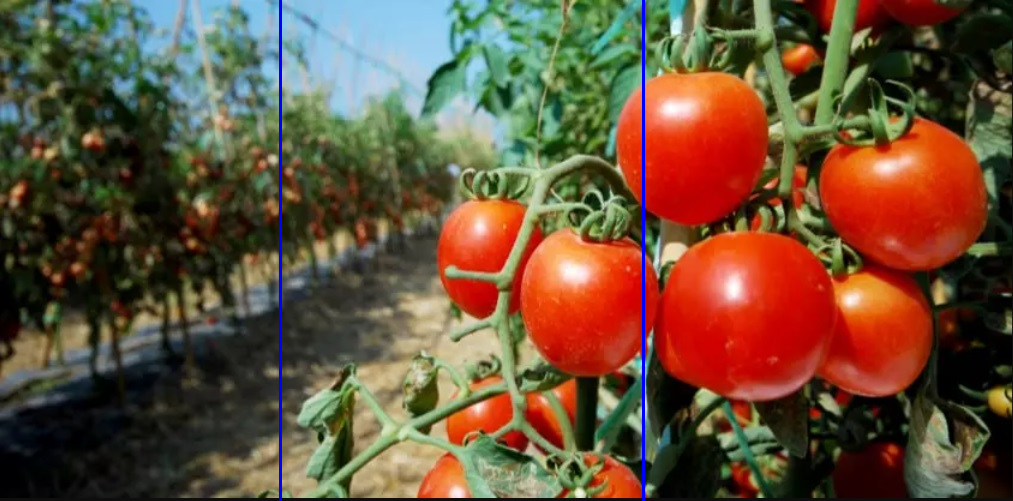

In [ ]:
# Exibir a imagem com as detecções
print("Detecção YOLOv5")
cv2_imshow(img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()